Time Calibration of the Mu2e Calorimeter

by Giacinto boccia

version 1.0 | 2024-09-10

In [456]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import awkward as ak
import uproot
import quantities as pq
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [457]:
#Cut parameters
YSPAN_CUT =         200 * pq.mm
HITNUM_CUT =        3       #6
V_MIN_CUT =         300     #Use 338 for 15 MeV 
V_MAX_CUT =         800     #Use 675 for 30 MeV
COS_THETA_CUT =     0.5     #0.2 
CHI_ON_NDF_CUT =    2       #2
VERTICALS =         True    #Allows verticl events
RES_NUM_CUT =       50      #Minimum number of residuals to calibrate a channel
#constants
CORR_FACTOR =   1
N_ROWS =        36
N_COLUMNS =     28
N_SIPMS =       2
CRY_SIDE =      34.4 * pq.mm

In [458]:
#Input
hits_path = input("Hits file to process [.root]:")
n_runs = int(input("Iterations to perform:"))
cal_path = input("Starting caibration file [Optional]:") or False
save_f_name = input("Calibration file to save [Deafault <hits>_t_calibration.csv]:") or False
if not save_f_name:
    save_f_name = hits_path[ : -5] + "_t_calibration.csv"
#Name of the tree inside the file
hits_path += ":sidet"

In [459]:
#Opening the calibration start-point file
if cal_path:
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns
    #Assuming that the file has a 3 row header and then row,col,sipm,t_cor(ns)
    with open(cal_path) as file:
        ext_cal = np.loadtxt(file, skiprows= 3, delimiter= ',')
        for ext_row in ext_cal:
            row, col, sipm, t_corr = ext_row
            cal_corection[int(row), int(col), int(sipm)] = np.double(t_corr) * pq.ns
else:
    #The time-correction array is [rows, columns, SiPM] shaped
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns

In [460]:
#Loading the tree, start by defining custom event class that can compute residurals
class Cosmic_Event_Class(ak.Record):     
    def t_residuals(self) -> dict | None:
        #returns a dictionary with '(row, col, sipm)' as key and the residual as value
        #Filters on the hit charge 
        v_min_fitler = self.Vmax > V_MIN_CUT
        v_max_fitler = self.Vmax < V_MAX_CUT
        v_filter = v_max_fitler & v_min_fitler
        if self.slope:
            #Select events that have a not "None" slope
            cos_theta = 1 / np.sqrt(1 + self.slope ** 2)
        elif self.vertical and VERTICALS:
            cos_theta = 0
        else:
            return None
        t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns
        t_res = dict()
        for i, [row, col, sipm] in enumerate(zip(self.iRow[v_filter],
                                                 self.iCol[v_filter],
                                                 self.SiPM[v_filter])):
            #Apply current time corrections
            t_arr[i] += cal_corection[row, col, sipm]
        v_arr = np.array(self.Vmax[v_filter])
        t0_ev = np.average(t_arr, weights= v_arr)
        for time, y, row, col, sipm in zip(t_arr, 
                                           self.Yval[v_filter],
                                           self.iRow[v_filter],
                                           self.iCol[v_filter],
                                           self.SiPM[v_filter]):
            #Each residual is stored in the dictionary with '(row, col, sipm)' as key
            y = y * pq.mm
            residual = time + y / (pq.c * cos_theta) - t0_ev
            t_res[str(row) + ', ' + str(col) + ', ' + str(sipm)] = residual.item()
        return t_res
    def y_span(self) -> pq.mm:
        if len(self.Yval) > 0:
            y_max = np.max(self.Yval)
            y_min = np.min(self.Yval)
            return (y_max-y_min) * pq.mm
        else:
            return np.nan * pq.mm
ak.behavior["cosmic"] = Cosmic_Event_Class
        
#Loading tree in an array structure, we only need some of the branches
branches = ("nrun", "nsubrun", "evnum", "nHits", "iRow", "iCol", "SiPM", "Xval", "Yval", "Vmax", "Tval", "templTime")
with uproot.open(hits_path) as file:
    tree = file.arrays(filter_name = branches)
    
#Now change the array so that it uses the custom class defned above
tree = ak.Array(tree, with_name= "cosmic")

In [461]:
#To get the parameters, each event is fitted
def linear_fit(event) -> dict[str, np.double | int]:
    v_min_fitler = event.Vmax > V_MIN_CUT
    v_max_fitler = event.Vmax < V_MAX_CUT
    x_arr = event.Xval[v_min_fitler & v_max_fitler] * pq.mm
    y_arr = event.Yval[v_min_fitler & v_max_fitler] * pq.mm
    if len(x_arr) > 1:
        #Events that are not empty
        if np.max(x_arr) - np.min(x_arr) > CRY_SIDE:
            #Events that are not vertical
            [slope, intercept], residuals, _, _, _ = np.polyfit(x_arr, y_arr, deg= 1, full= True)
            chi_sq : np.double = np.sum(residuals)
            ndf = event.nHits - 2
            return {'vertical' : False, 'slope' : slope, 'intercept' : intercept, 'chi_sq' : chi_sq, 'ndf' : ndf}
        else:
            #Vertical events get flagged
            return {'vertical': True, 'slope' : None, 'intercept' : None, 'chi_sq' : None, 'ndf' : None}
    else:
        return None
        
with ThreadPoolExecutor() as executor:
    fit_results = list(executor.map(linear_fit, tree))
fit_results = ak.Array(fit_results)

In [462]:
#Add the fit results to the tree
if hasattr(fit_results, 'vertical'):
    tree = ak.with_field(tree, fit_results.vertical,    "vertical")
    tree = ak.with_field(tree, fit_results.slope,       "slope")
    tree = ak.with_field(tree, fit_results.intercept,   "intercept")
    tree = ak.with_field(tree, fit_results.chi_sq,      "chi_sq")
    tree = ak.with_field(tree, fit_results.ndf,         "ndf")

In [463]:
#Apply the filters and compute the residuals
slope_cut = np.sqrt(1 / COS_THETA_CUT ** 2 - 1)
filters = {'n_min' :        tree.nHits > HITNUM_CUT,
           'slope_min' :    abs(tree.slope) > slope_cut,
           'chi_sq' :       tree.chi_sq / tree.ndf < CHI_ON_NDF_CUT,
           'vertical' :     tree.vertical}
filtered_events = tree[filters['n_min'] & 
                       filters['vertical'] | (filters['slope_min'] & filters['chi_sq'])]
filtered_events = ak.drop_none(filtered_events)

#We don't really need to store the means, unless we want to do a plot
mean_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns
sigma_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns ** 2
#We also wnat to plot the number of residuals taken for each channel
num_res_arr = np.zeros([n_runs, N_ROWS, N_COLUMNS, N_SIPMS])
res_arr_list = []
for run_n in range(n_runs):
    #Get the residuals
    def get_t_residuals(event) -> dict | None:
        if event.y_span() > YSPAN_CUT:
            return event.t_residuals()
        else:
            return None
    
    with ProcessPoolExecutor() as executor:
        residuals = list(executor.map(get_t_residuals, filtered_events))
    residuals = ak.Array(residuals)
    res_arr_list.append(residuals)

    def residuals_to_correction(channel : str) -> None:
        chan_address = tuple(int(entry) for entry in channel.split(', '))
        res_arr = np.array(ak.drop_none(residuals[channel]))
        num_res = np.count_nonzero(~np.isnan(res_arr))
        if num_res >= RES_NUM_CUT:
            mean_res, sigma = sp.norm.fit(res_arr)
            mean_res = mean_res * pq.ns
            sigma = sigma * pq.ns ** 2        
            sigma_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = sigma
            mean_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = mean_res
            num_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = num_res
            cal_corection[chan_address[0], chan_address[1], chan_address[2]] -= mean_res * CORR_FACTOR

    with ThreadPoolExecutor() as executor:
        #This funciton can't be parallelized with ProcessPoolExecutor, but there are a maximum of 1448 calls,
        #hopefully, ThreadPoolExecutor expedites it a little
        executor.map(residuals_to_correction, residuals.fields)

/tmp/ipykernel_1446/2470952333.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns
/tmp/ipykernel_1446/2470952333.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  v_arr = np.array(self.Vmax[v_filter])
/tmp/ipykernel_1446/2470952333.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns
/tmp/ipykernel_1446/2470952333.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' k

In [464]:
#Save the result
with open(save_f_name, mode = 'w') as file:
    print("Calorimeter time calibration values", file= file)
    print(n_runs, " Runs on file: ", hits_path, file= file)
    print("row_num,col_num,sipm_num,correction(ns)", file= file)
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                print(row, col, sipm, cal_corection[row, col, sipm].item(), file= file, sep= ",")

In [465]:
#Sep of genreations to be displayed on graphs
GRAPH_RUNS_STEP = 4

Text(0.5, 1.0, 'Residuals - Full Range')

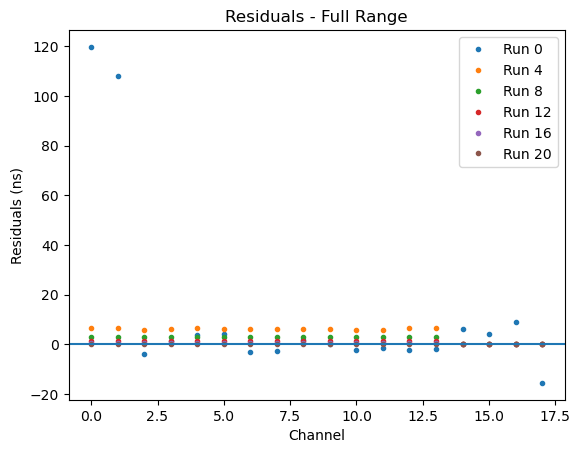

In [466]:
#Plot the residuals
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Residuals (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(mean_res_arr[run, row, col, sipm])
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
#ax.set_ybound(-100, 100)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Residuals - Full Range")

Text(0.5, 1.0, 'Residuals - Narrow Range')

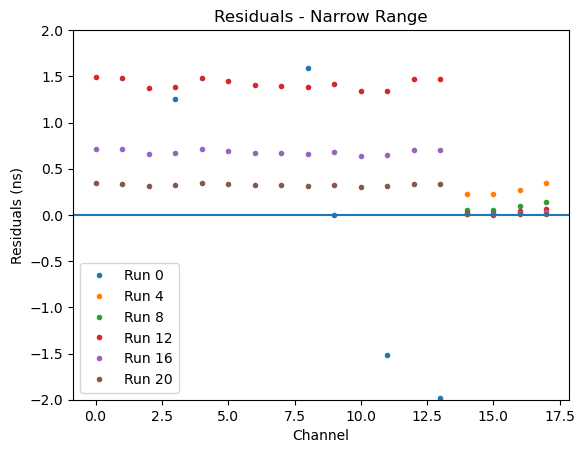

In [473]:
#Plot the residuals
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Residuals (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(mean_res_arr[run, row, col, sipm])
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
#ax.set_ybound(-100, 100)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Residuals - Narrow Range")

Text(0.5, 1.0, 'Number of residuals for each channel')

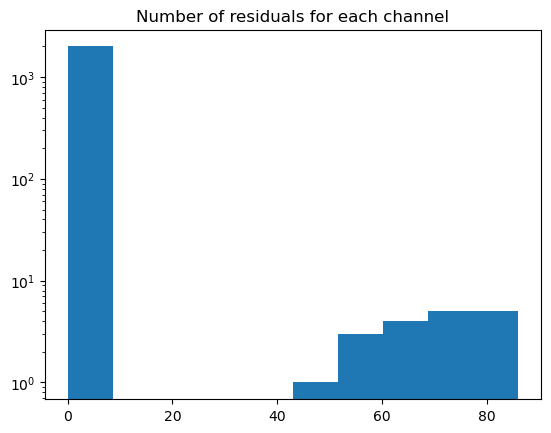

In [468]:
#Draw tht distrigution of the number of residuals for a specic generation over all the channles
plt.hist(num_res_arr[0].flatten(), label= "Run " + str(run))
plt.yscale('log')
plt.title("Number of residuals for each channel")

Text(0.5, 1.0, 'Mean Residuals (all channels) - full range [ns]')

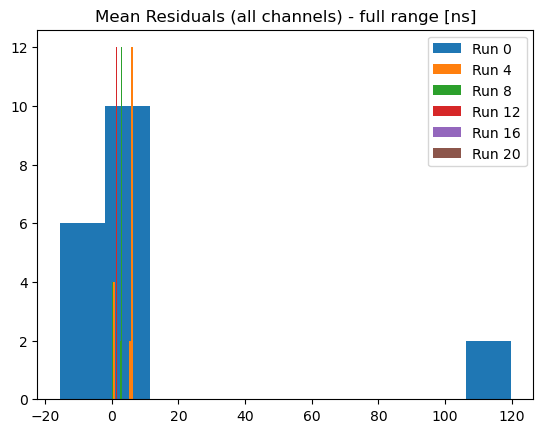

In [469]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - full range [ns]")

Text(0.5, 1.0, 'Mean Residuals (all channels) - narrow range [ns]')

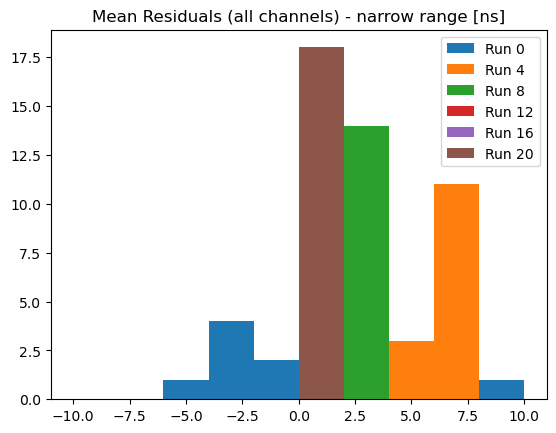

In [470]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, range= (-10, 10), label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - narrow range [ns]")

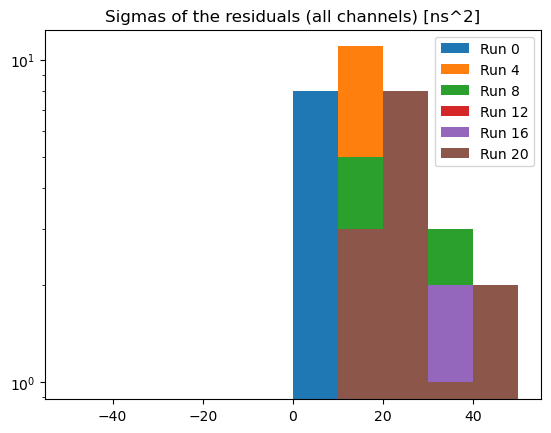

In [505]:
#Draw the distibutions of the sigma of the residuals
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    sigma_arr = []
    for sigma in sigma_res_arr[run].flatten():
        scalar = sigma.item()
        if not np.isnan(scalar):
            sigma_arr.append(scalar)
    n, bin, patches = plt.hist(sigma_arr, label= "Run " + str(run), range= (-50, 50))
plt.legend()
plt.title("Sigmas of the residuals (all channels) [ns^2]")
plt.yscale('log')

Text(0.5, 1.0, 'Residuals for Channel 4, 22, 1 ns')

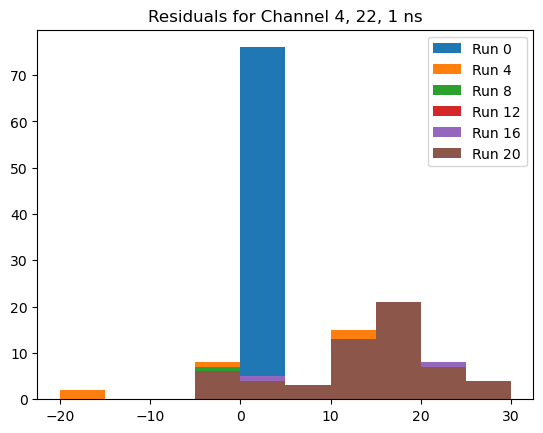

In [488]:
#Draw the distribution of the residuals for a specific chennel
ch_num = 21              #Refers to the number of channels that have events
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[residuals.fields[ch_num]], label= "Run " + str(run), range= (-20, 30))
plt.legend()
plt.title("Residuals for Channel " + residuals.fields[ch_num] + " ns")

In [489]:
channels = []
for row in range(N_ROWS):
    for col in range(N_COLUMNS):
        for sipm in range(N_SIPMS):
            if num_res_arr[0, row, col, sipm] >= RES_NUM_CUT:
                channels.append((row, col, sipm))
channels

[(3, 21, 0),
 (3, 21, 1),
 (4, 22, 0),
 (4, 22, 1),
 (5, 22, 0),
 (5, 22, 1),
 (6, 23, 0),
 (6, 23, 1),
 (7, 17, 0),
 (7, 17, 1),
 (8, 12, 0),
 (8, 12, 1),
 (9, 9, 0),
 (9, 9, 1),
 (16, 13, 0),
 (16, 13, 1),
 (22, 12, 0),
 (22, 12, 1)]

Text(0.5, 1.0, 'Residuals for Channel 16, 13, 0 ns')

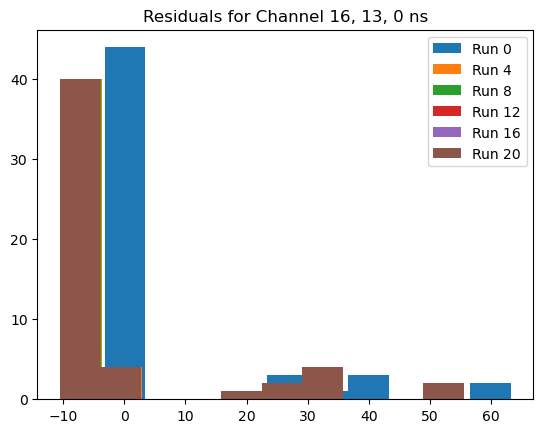

In [506]:
#Draw the distribution of the residuals for a specific chennel
channel = "16, 13, 0"
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[channel], label= "Run " + str(run))
plt.legend()
plt.title("Residuals for Channel " + channel + " ns")